<a href="https://colab.research.google.com/github/sclaudiobr/geocloud/blob/gh-pages/GeoCloud01_Altimetria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeoCloud 01 - Modelagem Digital de Elevação
<p>Esta ferramenta faz o download de dados de altimetria usando recortes terrritoriais dos municípios da base de dados do <i>IBGE</i>, através das biblioteca [geoBR](https://pypi.org/project/geobr/), recorta o quadrante sobre os dados do modelo de digital de elevação (MDE 30 metros) disponível na base de dados da USGS, através da biblioteca [elevation](https://pypi.org/project/elevation/) e aplica o tratamento para correção de fluxos e sumidouros de cursos dágua e extração dos valores de declividade através da biblioteca [richdem](https://pypi.org/project/richdem/). A operacionalização dos cálculos e conversões foram elaboradas com as bibliotecas de apoio [shapely, geopandas e rasterio] e apresentação visual dos mapas [contextily e mathplotlib.pyplot]. O processo se incia com a configuração do ambiente e importação dos dados, seguidos do recorte da área de interesse e conversão para UTM, finalizando com reclassificação do mapa de declividade e exportação do projeto em uma pasta zipada.<p>
<b>OBS:</b> Municípios com grande extensão territorial (> 150.000km2)  necessitam ser divididos para baixar os dados.
retornando o erro:
<p> ''RuntimeError: Too many tiles: 40. Please consult the providers' websites for how to bulk download tiles.''
<hr>

@autor Claudio Roberto Oliveira da Silva
<p> Bel. Lic. Ciências Biológicas - UNL/AM - 2005
<p>MSc. Modelagem Computacional, Eng. Civil - COPPE/UFRJ - 2008
<p>Tecnólogo de Geoprocessamento, Cursando - UFSM - 2018
<p>email: <a href= "mailto:claumao@gmail.com"> claumao@gmail.com</a>
<p> Repositório: <a href="https://github.com/sclaudiobr/"> GitHub</a>

In [ ]:
# INSTALA BIBLIOTECAS EXTERNAS
!pip install geobr # Base de dados do IBGE, Malhas municipais, biomas, microrregiões, sedes
!pip install elevation # Base de dados de elevação
!pip install richdem # Ferramenta de processamento de dados de elevação
!pip install rasterio # manipulação de arquivos raster/GDAL/Qgis
!pip install contextily # basemap
!pip install ipywidgets # uso posterior
!pip install ipyleaflet # uso posterior

In [ ]:
# IMPORTA AS BIBLIOTECAS
import geobr as br
import geopandas as gpd
import os
import numpy as np
from osgeo import gdal
import elevation as mde
import richdem as rd
from shapely.geometry import box
import matplotlib
import matplotlib.pyplot as plt
import contextily as ctx
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline
!eio selfcheck
# APAGA O PROJETO E RECOMEÇA OUTRO
!rm -r proj

# CRIA DIRETÓRIOS
!mkdir proj
!mkdir proj/shp
!mkdir proj/raster
!mkdir proj/raster/utm

# CRIA O VETOR DE ESTADOS
uf = np.array(['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN',
               'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC',
                'RS', 'MS', 'MT', 'GO', 'DF'])
# ESCOLHE O ESTADO
u = widgets.Dropdown(
    options=uf,
    description='Estado: ',
)
u

Your system is ready.
rm: cannot remove 'proj': No such file or directory


/usr/local/lib/python3.7/dist-packages/traitlets/traitlets.py:586: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


Dropdown(description='Estado: ', options=('RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN', 'P…

In [ ]:
# ESCOLHE UM MUNICÍPIO
d = br.read_municipality(code_muni=u.value)
#d = df[df.name_muni=='Santa Maria']
mn = widgets.Dropdown(
    options=d['name_muni'],
    description='Município: ',
)
mn

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Dropdown(description='Município: ', options=('Angra Dos Reis', 'Aperibé', 'Araruama', 'Areal', 'Armação Dos Bú…

Sistemas Geodésico: GEOGCRS["SIRGAS 2000",DATUM["Sistema de Referencia Geocentrico para las AmericaS 2000",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore."],BBOX[-59.87,-122.19,32.72,-25.28]],ID["EPSG",4674]]
----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


Novo Sistema Geodésico: GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]
-------------------------------

Área do Município: 67    1217.832222
dtype: float64 km2


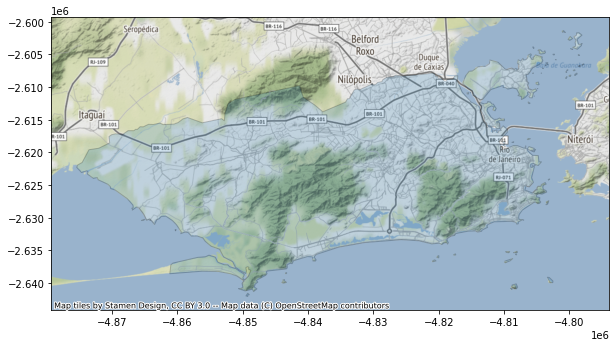

In [ ]:
# ACESSA OS DADOS DENTRO DO REPOSITÓRIO GEOBR
## salva a filtragem na base do IBGE na variável df
#df = br.read_municipality(code_muni=uf.value)
#rs = df
### Refina a busca por municípios
d = d[d.name_muni==mn.value]
df = gpd.GeoDataFrame(d)
# IMPRIME O DATUM
print("Sistemas Geodésico:",df.crs.geodetic_crs)
print('----------------------')
print('')
# CONVERTE O DATUM PARA WGS84 (O MESMO DO MDE)
df = df.to_crs(crs='EPSG:4326') #WGS 84
print("Novo Sistema Geodésico:",df.crs.geodetic_crs)
print('-------------------------------')
print('')
# EXTRAI AS COORDENADAS DOS CANTOS DO QUADRADO
dfbox = box(*df.total_bounds).bounds
latitude,longitude = np.array(dfbox)[1],np.array(dfbox)[2]
# SALVA OS ARQUIVOS NA PASTA
df.to_file('./proj/shp/df.shp', driver='ESRI Shapefile')
df = df.to_crs('EPSG:3857') # converte para Cartesiano (Transverso Mercator)                            # este basemap  só aceita cartesiano
ax = df.plot(figsize=(10, 10), alpha=0.2, edgecolor='k')
ctx.add_basemap(ax)
# converte de volta para SIRGAS 2000UTM 22S para calcular a área
print('Área do Município:',df.to_crs('EPSG:31982').area/1000000,'km2') 

# ALTIMETRIA

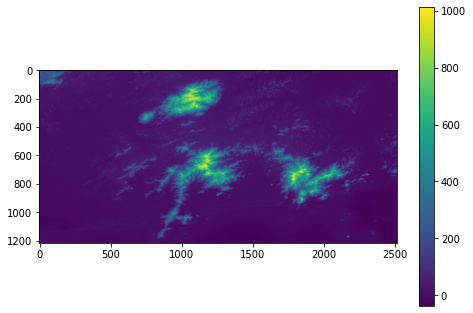

In [ ]:
# Recorte da área de estudo e salva no arquivo tif
mde.clip(bounds= dfbox, output='/content/proj/raster/dem.tif')
# gera a figura de plotagem
matplotlib.rcParams['figure.figsize'] = (8, 5.5)
# Define a pasta de trabalho
dem_path = os.path.join(os.getcwd(), 'proj/raster/dem.tif')
dem = rd.LoadGDAL(dem_path)
# preenche os espaços (buracos na imagem)
fill = rd.FillDepressions(dem, epsilon=False, in_place=False, topology='D8')
beau_breached = rd.BreachDepressions(fill, in_place=False)
rd.SaveGDAL('proj/raster/fill_dem.tif',beau_breached)
plt.imshow(beau_breached, interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
# RECORTA COM O VETOR DO MUNICÍPIO
import fiona
import rasterio
import rasterio.mask

with fiona.open("proj/shp/df.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rasterio.open("proj/raster/fill_dem.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("proj/raster/masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
# CONVERTE DE CGS-WGS 84 --> UTM-SIRGAS 2000 22S
!gdalwarp -s_srs epsg:4326 -t_srs epsg:31982 /content/proj/raster/masked.tif /content/proj/raster/utm/masked_utm.tif

Creating output file that is 2536P x 1415L.
Processing input file /content/proj/raster/masked.tif.
Using internal nodata values (e.g. -32768) for image /content/proj/raster/masked.tif.
Copying nodata values from source /content/proj/raster/masked.tif to destination /content/proj/raster/utm/masked_utm.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


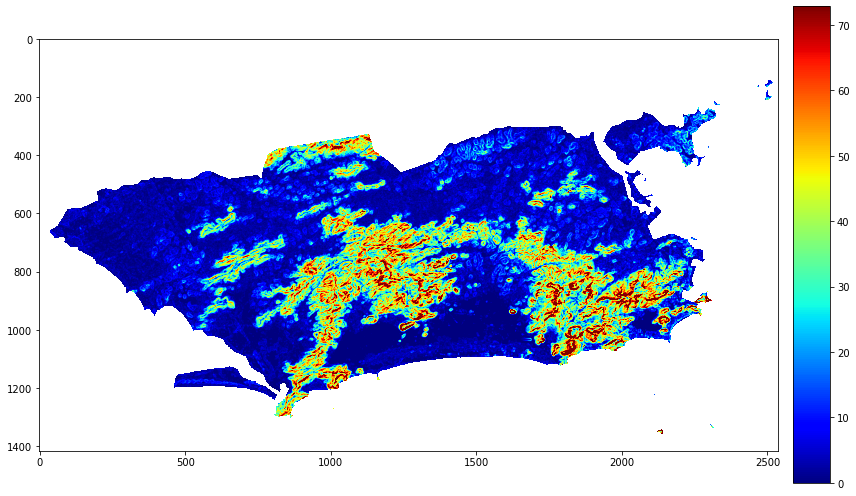

In [ ]:
# PLOTA RECORTE
fdem = rd.LoadGDAL('proj/raster/utm/masked_utm.tif')
slope = rd.TerrainAttribute(fdem, attrib='slope_percentage')
rd.rdShow(slope, axes=True, cmap='jet', figsize=(12, 7))
plt.show()
rd.SaveGDAL('proj/raster/utm/slope.tif' , slope)

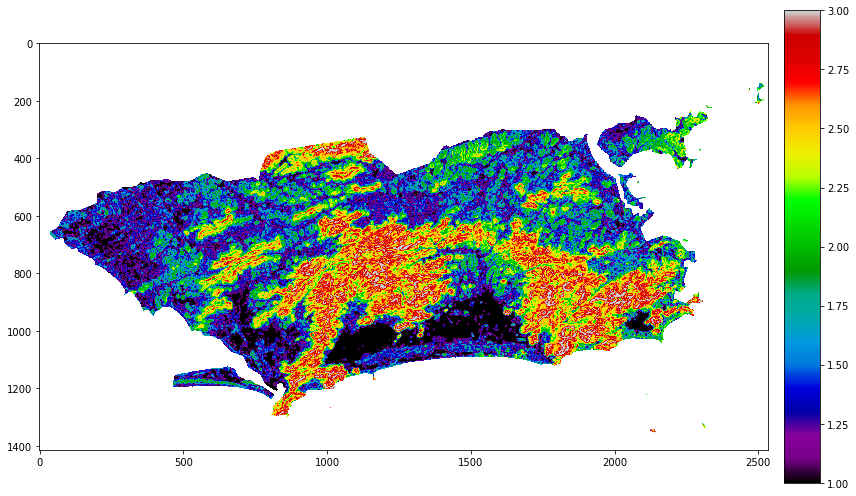

In [ ]:
# RECLASSIFICA do MAPA DE DECLIVIDADE (Crepani et al., 2001)
import copy
#Realiza uma cópia da matriz
new_matrix = copy.copy(slope)
# reclassificação =  converte os intervalos de declividade para classes de valores inteiros
new_matrix[np.where((0 <= slope) & (slope < 2)) ] = 1.0 # Estável
new_matrix[np.where((2 <= slope) & (slope < 6)) ] = 1.5 # Medianamente Estável
new_matrix[np.where((6 <= slope) & (slope < 20  )) ] = 2.0 #Moderadamente estável vi
new_matrix[np.where((20 <= slope) & (slope < 50)) ] = 2.5 # Moderadamente Vulnerável
new_matrix[np.where((slope > 50)) ] = 3.0
# salva amatriz de dados
rd.SaveGDAL('proj/raster/utm/slope_reclas.tif' , new_matrix)
reclass = rd.LoadGDAL('proj/raster/utm/slope_reclas.tif',no_data=None)
rd.rdShow(reclass, axes=True, cmap='nipy_spectral', figsize=(12, 7),)
plt.show()

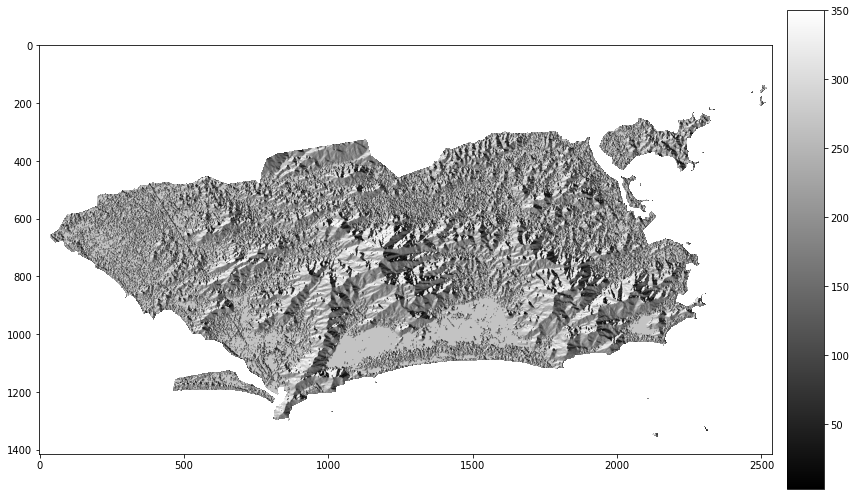

In [ ]:
# CRIA SOMBREAMENTO
aspect = rd.TerrainAttribute(fdem, attrib='aspect')
rd.rdShow(aspect, axes=True, cmap='gray', figsize=(12,7))
plt.show()
rd.SaveGDAL('proj/raster/utm/aspect.tif' , aspect)

In [ ]:
# COMPRIME PASTA DO PROJETO
import zipfile
import os
fantasy_zip = zipfile.ZipFile('projeto.zip', 'w')
for folder, subfolders, files in os.walk('./proj/'):
    for file in files:
        fantasy_zip.write(os.path.join(folder, file), file, compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.close()